In [1]:
from __future__ import annotations
%reload_ext autoreload
%autoreload 2
from IPython.display import Math
from tqdm import tqdm
import sys
import os
parent_path = os.path.abspath("..")
if parent_path not in sys.path:
    sys.path.append(parent_path)
from dataclasses import dataclass

# For a quick config:
# import logging
# logging.basicConfig(
#     format="%(asctime)s [%(levelname)s] [%(name)s]: %(message)s",
#     level=logging.DEBUG
# )

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import sympy
import numpy as np
import numpy.typing as npt
import typing
from typing import Callable, Dict, List, Optional, Tuple, Union, Iterable
import qutip # type: ignore

from src.quantum_utils import measure_povm, sic_povm, mub_povm, random_rank1_povm
from src.qelm_utils import analyze_biasvar_vs_nstates, analyze_biasvar_vs_statistics

from src.shadow_tomography import QuantumState, frame_operator
from src.utils import pp_matrix
from src import QELM

def logspace(start: float, stop: float, num: int) -> npt.NDArray[np.float64]:
    """Generate logarithmically spaced values between start and stop."""
    return np.logspace(np.log10(start), np.log10(stop), num=num, base=10.0)


In [2]:
def matrix_block_decomposition(deficient_matrix, fullrank_matrix, rtol=1e-15) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Decomposes a full rank matrix into blocks based on the support and image of another (generally deficient) matrix.
    """
    # compute the SVD of the deficient matrix
    U, D, Vt = np.linalg.svd(deficient_matrix, full_matrices=True)
    rank = np.sum(np.abs(D) > rtol)
    # project the full rank matrix onto the support and image of the deficient matrix
    U_im = U[:, :rank]
    U_imperp = U[:, rank:]
    V = Vt.T
    V_supp = V[:, :rank]
    V_suppperp = V[:, rank:]
    # compute the blocks
    block_11 = U_im.T @ fullrank_matrix @ V_supp
    block_12 = U_im.T @ fullrank_matrix @ V_suppperp
    block_21 = U_imperp.T @ fullrank_matrix @ V_supp
    block_22 = U_imperp.T @ fullrank_matrix @ V_suppperp
    # return the blocks
    return block_11, block_12, block_21, block_22

@dataclass
class PseudoInverseApproximator:
    """
    Approximates the pseudoinverse of a perturbed matrix P_true + eps * X
    using block expansions on the support and image of P_true.
    """
    P_true: np.ndarray
    eps: float
    X: np.ndarray
    tol: float = 1e-10
    order : int = 1

    def __post_init__(self):
        # Compute SVD and determine rank of P_true
        U, D, Vdag = np.linalg.svd(self.P_true, full_matrices=True)
        self.U = U
        self.D = D
        self.Vdag = Vdag
        self.rank = int(np.sum(D > self.tol))

        # Split into support and its orthogonal complement
        self.U_im = U[:, :self.rank]
        self.U_perp = U[:, self.rank:]
        V = Vdag.T
        self.V_supp = V[:, :self.rank]
        self.V_perp = V[:, self.rank:]

    def _blocks(self, M: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        """
        Project matrix M onto blocks determined by the support/image decomposition
        Returns: M11, M12, M21, M22
        """
        M11 = self.U_im.T @ M @ self.V_supp
        M12 = self.U_im.T @ M @ self.V_perp
        M21 = self.U_perp.T @ M @ self.V_supp
        M22 = self.U_perp.T @ M @ self.V_perp
        return M11, M12, M21, M22

    def approximate(self, order=1) -> PseudoInverseApproximator:
        """
        Compute the first-order approximation of the pseudoinverse of
        P_true + eps * X, returning the block components A, B, C, D and
        the full approximate inverse.
        """
        if order > 1:
            raise ValueError("Only first-order approximation is implemented.")
        elif order < 0:
            raise ValueError('Order must be non-negative, what the fuck does {order} mean here?')
        # Original and perturbation blocks
        P11, P12, P21, P22 = self._blocks(self.P_true)
        X11, X12, X21, X22 = self._blocks(self.X)

        # Inverses / pseudo-inverses of diagonal blocks
        Pinv = np.linalg.inv(P11)
        X22inv = np.linalg.pinv(X22)
        # projection on ker of X22, in 22 support block
        Pi2 = (np.eye(X22.shape[1]) - X22inv @ X22)
        Qinv = np.linalg.inv(X22 @ X22.T)

        # Singular term
        Dm1 = X22inv

        # Leading order (eps^0) blocks
        A = A0 = Pinv
        B = B0 = -Pinv @ X12 @ X22inv
        C = C0 = -X22inv @ X21 @ Pinv
        D0 = X22inv @ X21 @ Pinv @ X12 @ X22inv
        # correction term due to the non-squaredness
        nonsquared_term = -Pi2 @ X12.T @ Pinv.T @ X21.T @ Qinv
        D0 += nonsquared_term
        D = Dm1 / self.eps + D0

        if order >= 1:
            # precompute Schur complement etc
            scX = (X11 - X12 @ X22inv @ X21)
            Y = np.eye(P11.shape[0]) + X21.T @ Qinv @ X21
            # First-order (eps^1) corrections
            A1 = -Pinv @ scX @ Pinv
            B1 = Pinv @ scX @ Pinv @ X12 @ X22inv
            C1 = X22inv @ X21 @ Pinv @ scX @ Pinv
            # D1 = X22inv @ X21 @ Pinv @ (X11 @ B0 + X12 @ D0)
            D1 = - X22inv @ X21 @ Pinv @ scX @ Pinv @ X12 @ X22inv
            # additional correction terms for the non-squaredness
            B1 += Pinv @ X12 @ Pi2 @ X12.T @ Pinv.T @ X21.T @ Qinv
            C1 += Pi2 @ X12.T @ Pinv.T @ Y @ Pinv
            D1 += -Pi2 @ X12.T @ Pinv.T @ Y @ Pinv @ X12 @ X22inv
            D1 += Pi2 @ X12.T @ Pinv.T @ scX.T @ Pinv.T @ X21.T @ Qinv
            D1 += -X22inv @ X21 @ Pinv @ X12 @ Pi2 @ X12.T @ Pinv.T @ X21.T @ Qinv

            # Assemble approximate blocks
            A += self.eps * A1
            B += self.eps * B1
            C += self.eps * C1
            D += self.eps * D1

        # now that we have the blocks, we can compute the full approximate pseudoinverse
        # remembering that we changed bases to the support and image of P_true, so we must change back
        # to the original basis using the transpose of the change of basis matrices
        # (keeping into account that we now revert basis AFTER the pseudoinverse, which changes the block structure)
        A_ = self.V_supp @ A @ self.U_im.T
        B_ = self.V_supp @ B @ self.U_perp.T
        C_ = self.V_perp @ C @ self.U_im.T
        D_ = self.V_perp @ D @ self.U_perp.T
        approx_pinv = A_ + B_ + C_ + D_
        # Store the blocks and the full approximate pseudoinverse
        self.A = A
        self.B = B
        self.C = C
        self.D = D
        self.approx_pinv = approx_pinv

        return self

# Verifying discontinuity of pseudoinverse

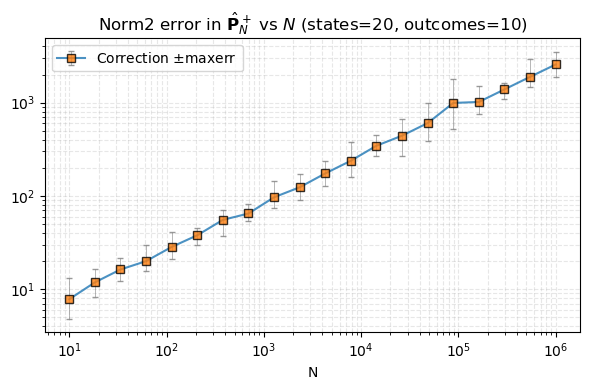

In [68]:
def correction(training_states, povm, stat):
    # True outcome probabilities at infinite stats
    P_true = measure_povm(states=training_states, povm=povm, statistics=np.inf, return_frequencies=True)
    P_est = measure_povm(states=training_states, povm=povm, statistics=stat, return_frequencies=True)
    Mrho = np.array([QuantumState(s).vectorise() for s in training_states]).T
    Mmu = np.array([QuantumState(s).vectorise() for s in povm]).T
    true = np.linalg.pinv(P_true)
    est = np.linalg.pinv(P_est)
    return np.linalg.norm(true - est, ord=2)

dim = 2
n_states = 20
n_outcomes = 10
n_realizations = 10  # number of independent runs per shot count
training_states = [qutip.rand_ket(dim) for _ in range(n_states)]
# test_state = qutip.rand_ket(dim)
povm = random_rank1_povm(dim, n_outcomes)

err_means = []
err_highs = []
err_lows = []
stats_list = logspace(10, 10**6, num=20)
for stats in stats_list:
    # empirical bias^2 over multiple realizations
    err_vals = []
    for _ in range(n_realizations):
        err_vals.append(correction(training_states, povm, stats))

    err_vals = np.array(err_vals)
    err_mean = err_vals.mean()
    err_means.append(err_mean)
    # se_emp   = emp_vals.std(ddof=1) / np.sqrt(n_realizations)
    err_highs.append(err_vals.max() - err_mean)
    err_lows.append(err_mean - err_vals.min())
df = pd.DataFrame({'stats_list': stats_list, 'err_means': err_means, 'err_highs': err_highs, 'err_lows': err_lows})
# Plot with error bars
plt.figure(figsize=(6,4))
plt.errorbar(
    df['stats_list'], df['err_means'],
    yerr=[df['err_lows'], df['err_highs']],
    marker='s', markersize=6, markeredgewidth=1, markeredgecolor='black', markerfacecolor='C1',
    alpha=0.8, ecolor='gray', elinewidth=0.5, capsize=2, capthick=0.5,
    label=r'Correction $\pm{\rm maxerr}$'
)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('N')
# plt.ylabel(r'$\|\mathbf{P}^+ - \hat{\mathbf{P}}^+_N\|_2$')
plt.title(f'Norm2 error in $\\hat{{\\mathbf{{P}}}}_N^+$ vs $N$ (states={n_states}, outcomes={n_outcomes})')
plt.grid(True, which='both', ls='--', alpha=0.3)
plt.legend(); plt.tight_layout(); plt.show()


In [35]:
dim = 2
n_states = 4
n_outcomes = 4
n_realizations = 10  # number of independent runs per shot count
training_states = [qutip.rand_ket(dim) for _ in range(n_states)]
povm = random_rank1_povm(dim, n_outcomes)
P_true = measure_povm(states=training_states, povm=povm, statistics=np.inf, return_frequencies=True)
P_est = measure_povm(states=training_states, povm=povm, statistics=10**5, return_frequencies=True)

print(np.linalg.svd(P_est, full_matrices=False, compute_uv=False))
print(np.linalg.svd(P_true, full_matrices=False, compute_uv=False))


[1.07142782 0.56408179 0.13099159 0.0252663 ]
[1.07114376 0.56422695 0.13144143 0.02422878]


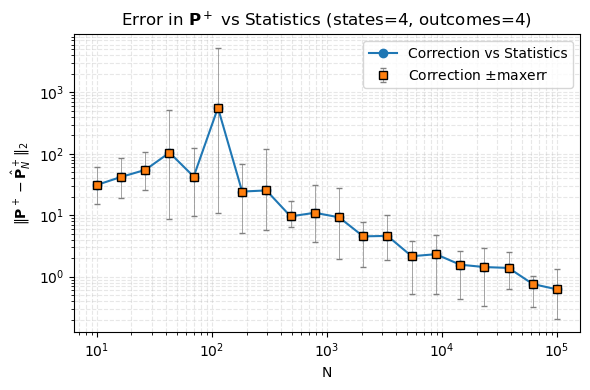

In [41]:
def correction(training_states, povm, stat):
    # True outcome probabilities at infinite stats
    P_true = measure_povm(states=training_states, povm=povm, statistics=np.inf, return_frequencies=True)
    P_est = measure_povm(states=training_states, povm=povm, statistics=stat, return_frequencies=True)
    # Vectorised test state mapping
    Ppinv_true = np.linalg.pinv(P_true)
    Ppinv_est = np.linalg.pinv(P_est)
    return np.linalg.norm(Ppinv_true - Ppinv_est, ord=2)

dim = 2
n_states = 4
n_outcomes = 4
n_realizations = 10  # number of independent runs per shot count
training_states = [qutip.rand_ket(dim) for _ in range(n_states)]
# test_state = qutip.rand_ket(dim)
povm = random_rank1_povm(dim, n_outcomes)

err_means = []
err_highs = []
err_lows = []
stats_list = logspace(10, 100000, num=20)
for stats in stats_list:
    # empirical bias^2 over multiple realizations
    err_vals = []
    for _ in range(n_realizations):
        err_vals.append(correction(training_states, povm, stats))

    err_vals = np.array(err_vals)
    err_mean = err_vals.mean()
    err_means.append(err_mean)
    # se_emp   = emp_vals.std(ddof=1) / np.sqrt(n_realizations)
    err_highs.append(err_vals.max() - err_mean)
    err_lows.append(err_mean - err_vals.min())

# Assemble DataFrame
df = pd.DataFrame({
    'stats_list': stats_list,
    'err_means': err_means,
    'err_highs': err_highs,
    'err_lows': err_lows
})

# Plot with error bars
plt.figure(figsize=(6,4))
# theoretical curve
plt.plot(df['stats_list'], df['err_means'],
         marker='o', label=r'Correction vs Statistics')
# empirical mean ± standard error
plt.errorbar(
    df['stats_list'], df['err_means'],
    yerr=[df['err_lows'], df['err_highs']],
    marker='s', ls='none',
    markersize=6,           # larger markers
    markeredgewidth=1,
    markeredgecolor='black',
    markerfacecolor='C1',
    alpha=1.0,              # fully opaque points
    ecolor='gray',          # error bars in gray
    elinewidth=0.5,         # thinner error bars
    capsize=2,              # small caps
    capthick=0.5,
    label=r'Correction $\pm{\rm maxerr}$'
)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('N')
plt.ylabel(r'$\|\mathbf{P}^+ - \hat{\mathbf{P}}^+_N\|_2$')
# add number of states and outcomes to the title
plt.title(f'Error in $\\mathbf{{P}}^+$ vs Statistics (states={n_states}, outcomes={n_outcomes})')
plt.grid(True, which='both', ls='--', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


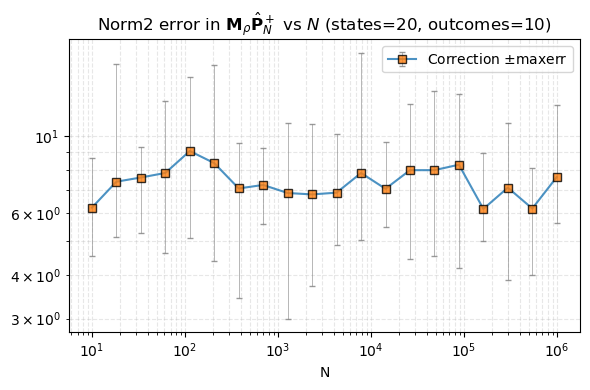

In [67]:
def correction(training_states, povm, stat):
    # True outcome probabilities at infinite stats
    P_true = measure_povm(states=training_states, povm=povm, statistics=np.inf, return_frequencies=True)
    P_est = measure_povm(states=training_states, povm=povm, statistics=stat, return_frequencies=True)
    Mrho = np.array([QuantumState(s).vectorise() for s in training_states]).T
    Mmu = np.array([QuantumState(s).vectorise() for s in povm]).T
    true = Mrho @ np.linalg.pinv(P_true)
    est = Mrho @ np.linalg.pinv(P_est)
    return np.linalg.norm(true - est, ord=2)

dim = 2
n_states = 20
n_outcomes = 10
n_realizations = 10  # number of independent runs per shot count
training_states = [qutip.rand_ket(dim) for _ in range(n_states)]
# test_state = qutip.rand_ket(dim)
povm = random_rank1_povm(dim, n_outcomes)

err_means = []
err_highs = []
err_lows = []
stats_list = logspace(10, 10**6, num=20)
for stats in stats_list:
    # empirical bias^2 over multiple realizations
    err_vals = []
    for _ in range(n_realizations):
        err_vals.append(correction(training_states, povm, stats))

    err_vals = np.array(err_vals)
    err_mean = err_vals.mean()
    err_means.append(err_mean)
    # se_emp   = emp_vals.std(ddof=1) / np.sqrt(n_realizations)
    err_highs.append(err_vals.max() - err_mean)
    err_lows.append(err_mean - err_vals.min())
df = pd.DataFrame({'stats_list': stats_list, 'err_means': err_means, 'err_highs': err_highs, 'err_lows': err_lows})
# Plot with error bars
plt.figure(figsize=(6,4))
plt.errorbar(
    df['stats_list'], df['err_means'],
    yerr=[df['err_lows'], df['err_highs']],
    marker='s', markersize=6, markeredgewidth=1, markeredgecolor='black', markerfacecolor='C1',
    alpha=0.8, ecolor='gray', elinewidth=0.5, capsize=2, capthick=0.5,
    label=r'Correction $\pm{\rm maxerr}$'
)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('N')
# plt.ylabel(r'$\|\mathbf{P}^+ - \hat{\mathbf{P}}^+_N\|_2$')
plt.title(f'Norm2 error in $\\mathbf{{M}}_\\rho\\hat{{\\mathbf{{P}}}}_N^+$ vs $N$ (states={n_states}, outcomes={n_outcomes})')
plt.grid(True, which='both', ls='--', alpha=0.3)
plt.legend(); plt.tight_layout(); plt.show()


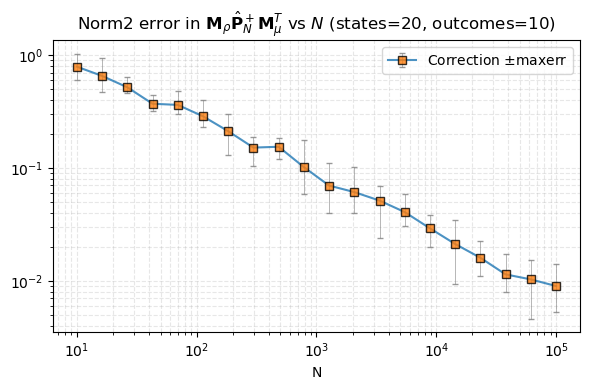

In [64]:
def correction(training_states, povm, stat):
    # True outcome probabilities at infinite stats
    P_true = measure_povm(states=training_states, povm=povm, statistics=np.inf, return_frequencies=True)
    P_est = measure_povm(states=training_states, povm=povm, statistics=stat, return_frequencies=True)
    Mrho = np.array([QuantumState(s).vectorise() for s in training_states]).T
    Mmu = np.array([QuantumState(s).vectorise() for s in povm]).T
    true = Mrho @ np.linalg.pinv(P_true) @ Mmu.T
    est = Mrho @ np.linalg.pinv(P_est) @ Mmu.T
    return np.linalg.norm(true - est, ord=2)

dim = 2
n_states = 20
n_outcomes = 10
n_realizations = 10  # number of independent runs per shot count
training_states = [qutip.rand_ket(dim) for _ in range(n_states)]
# test_state = qutip.rand_ket(dim)
povm = random_rank1_povm(dim, n_outcomes)

err_means = []
err_highs = []
err_lows = []
stats_list = logspace(10, 100000, num=20)
for stats in stats_list:
    # empirical bias^2 over multiple realizations
    err_vals = []
    for _ in range(n_realizations):
        err_vals.append(correction(training_states, povm, stats))

    err_vals = np.array(err_vals)
    err_mean = err_vals.mean()
    err_means.append(err_mean)
    # se_emp   = emp_vals.std(ddof=1) / np.sqrt(n_realizations)
    err_highs.append(err_vals.max() - err_mean)
    err_lows.append(err_mean - err_vals.min())
df = pd.DataFrame({'stats_list': stats_list, 'err_means': err_means, 'err_highs': err_highs, 'err_lows': err_lows})
# Plot with error bars
plt.figure(figsize=(6,4))
plt.errorbar(
    df['stats_list'], df['err_means'],
    yerr=[df['err_lows'], df['err_highs']],
    marker='s', markersize=6, markeredgewidth=1, markeredgecolor='black', markerfacecolor='C1',
    alpha=0.8, ecolor='gray', elinewidth=0.5, capsize=2, capthick=0.5,
    label=r'Correction $\pm{\rm maxerr}$'
)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('N')
# plt.ylabel(r'$\|\mathbf{P}^+ - \hat{\mathbf{P}}^+_N\|_2$')
plt.title(f'Norm2 error in $\\mathbf{{M}}_\\rho\\hat{{\\mathbf{{P}}}}_N^+\\mathbf{{M}}_\\mu^T$ vs $N$ (states={n_states}, outcomes={n_outcomes})')
plt.grid(True, which='both', ls='--', alpha=0.3)
plt.legend(); plt.tight_layout(); plt.show()


# Pseudoinverse expansion verification

Verify that the singular values of $\hat{\bf P}_N\equiv \mathbf P+\frac{1}{\sqrt N}\hat{\bf X}$ behave as expected: the first $\operatorname{rank}(\mathbf P)$ ones are constant, while all the others are decrease as $1/\sqrt N$.

Training statistics: 100%|██████████| 20/20 [00:00<00:00, 21.84it/s] 
C:\Users\lukei\AppData\Local\Temp\ipykernel_39216\2490822928.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


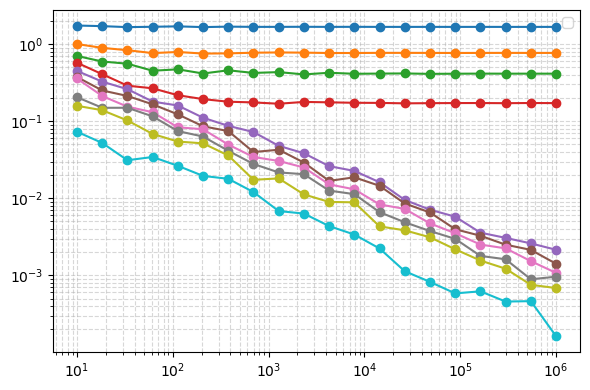

In [45]:
Ptrue = measure_povm(states=training_states, povm=povm, statistics=np.inf, return_frequencies=True)
Ptrue_inv = np.linalg.pinv(Ptrue)
train_stat_list = logspace(10, 10**6, num=20)
data = dict(svalues=[], train_stat=train_stat_list)
for train_stat in tqdm(train_stat_list, desc='Training statistics'):
    Pest = measure_povm(states=training_states, povm=povm, statistics=train_stat, return_frequencies=True)
    data['svalues'].append(np.linalg.svd(Pest, compute_uv=False))
# plot the errors as a function of the training statistics
plt.figure(figsize=(6,4))
plt.plot(data['train_stat'], data['svalues'], marker='o')
plt.xscale('log')
plt.yscale('log')
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

Here we check that the matrix block decomposition works as intended: computing $\mathbf P^+$ and extracting the support-image block gives the same singular values as those of $\mathbf P^+$ itself. Whereas the other 3 blocks are compatible with the zero matrix:

In [36]:
Ptrue_inv = np.linalg.pinv(Ptrue)
Ptrue_inv_11, Ptrue_inv_12, Ptrue_inv_21, Ptrue_inv_22 = matrix_block_decomposition(Ptrue_inv, Ptrue_inv, rtol=1e-15)
# print singular values of Pest_inv_11
print('singular values of Ptrue_inv_11:', np.linalg.svd(Ptrue_inv_11, compute_uv=False))
print('singular values of Ptrue_inv:', np.linalg.svd(Ptrue_inv, compute_uv=False))
print('maxabs of elements in the other 3 blocks:', np.max(np.abs(Ptrue_inv_12)), np.max(np.abs(Ptrue_inv_21)), np.max(np.abs(Ptrue_inv_22)))

singular values of Ptrue_inv_11: [5.81434212 2.41407169 1.2992208  0.59685998]
singular values of Ptrue_inv: [5.81434212e+00 2.41407169e+00 1.29922080e+00 5.96859984e-01
 6.23026449e-16 2.95736268e-16 1.54502336e-16 1.41090282e-16
 9.22318326e-17 2.00317019e-17]
maxabs of elements in the other 3 blocks: 1.2212453270876722e-15 1.1657930172636776e-15 1.5027071764795892e-16


Check that the singularity in $(\mathbf P+\epsilon \hat{\bf X})^+$ is confined to the 22 block (the one orthogonal to $\operatorname{supp}(\mathbf P)$ and $\operatorname{im}(\mathbf P)$). We can also see how the singularity (in norm here) increases as $\sqrt N$:

Training statistics: 100%|██████████| 20/20 [00:00<00:00, 21.52it/s] 


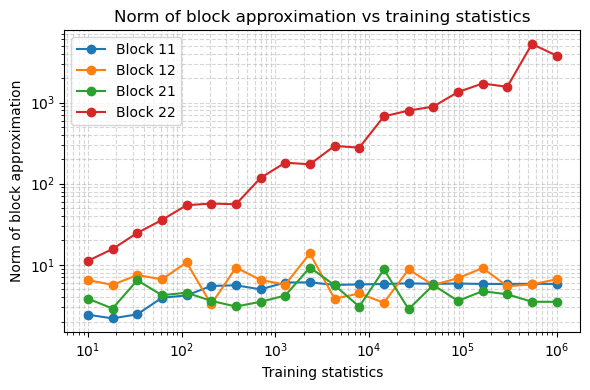

In [43]:
Ptrue = measure_povm(states=training_states, povm=povm, statistics=np.inf, return_frequencies=True)
Ptrue_inv = np.linalg.pinv(Ptrue)
train_stat_list = logspace(10, 10**6, num=20)
data = dict(norm11=[], norm12=[], norm21=[], norm22=[], train_stat=train_stat_list)
for train_stat in tqdm(train_stat_list, desc='Training statistics'):
    Pest = measure_povm(states=training_states, povm=povm, statistics=train_stat, return_frequencies=True)
    Pest_inv = np.linalg.pinv(Pest)
    Pest_inv_11, Pest_inv_12, Pest_inv_21, Pest_inv_22 = matrix_block_decomposition(Ptrue_inv, Pest_inv, rtol=1e-15)
    # print singular values of Pest_inv_11
    data['norm11'].append(np.linalg.norm(Pest_inv_11, ord=2))
    data['norm12'].append(np.linalg.norm(Pest_inv_12, ord=2))
    data['norm21'].append(np.linalg.norm(Pest_inv_21, ord=2))
    data['norm22'].append(np.linalg.norm(Pest_inv_22, ord=2))
# plot the errors as a function of the training statistics
plt.figure(figsize=(6,4))
plt.plot(data['train_stat'], data['norm11'], label='Block 11', marker='o')
plt.plot(data['train_stat'], data['norm12'], label='Block 12', marker='o')
plt.plot(data['train_stat'], data['norm21'], label='Block 21', marker='o')
plt.plot(data['train_stat'], data['norm22'], label='Block 22', marker='o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Training statistics')
plt.ylabel('Norm of block approximation')
plt.title('Norm of block approximation vs training statistics')
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

Double check the individual blocks in the pseudoinverse approximation formula:

In [86]:
dim, n_states, n_outcomes = 2, 20, 10
training_states = [qutip.rand_ket(dim) for _ in range(n_states)]
povm = random_rank1_povm(dim, n_outcomes)
Ptrue = measure_povm(states=training_states, povm=povm, statistics=np.inf, return_frequencies=True)
Ptrue_inv = np.linalg.pinv(Ptrue)
Pest = measure_povm(states=training_states, povm=povm, statistics=train_stat, return_frequencies=True)
train_stat = 10**4
eps = 1 / np.sqrt(train_stat)
X = (Pest - Ptrue) / eps

approximator = PseudoInverseApproximator(P_true=Ptrue, eps=eps, X=X)
approximator.approximate(order=0)
block11 = approximator.A
block12 = approximator.B
block21 = approximator.C
block22 = approximator.D

# manually redecompose X to get the blocks
X11, X12, X21, X22 = matrix_block_decomposition(Ptrue, X)
P11, _, _, _ = matrix_block_decomposition(Ptrue, Ptrue)
block12_from_formula = -np.linalg.pinv(P11) @ X12 @ np.linalg.pinv(X22)
block21_from_formula = -np.linalg.pinv(X22) @ X21 @ np.linalg.pinv(P11)
block22_from_formula = np.linalg.pinv(X22) @ X21 @ np.linalg.pinv(P11) @ X12 @ np.linalg.pinv(X22)
block22_from_formula += np.linalg.pinv(X22) / eps

# print error in the blocks
print('norm error in block11:', np.linalg.norm(block11 - np.linalg.pinv(P11), ord=2))
print('norm error in block12:', np.linalg.norm(block12 - block12_from_formula, ord=2))
print('norm error in block21:', np.linalg.norm(block21 - block21_from_formula, ord=2))
print('norm error in block22:', np.linalg.norm(block22 - block22_from_formula, ord=2))


norm error in block11: 1.1327339526728032e-15
norm error in block12: 2.0755796823202562e-15
norm error in block21: 1.0832004220292944e-15
norm error in block22: 3.580361673049448e-15


Denoting with $\hat{\bf P}^{+(k)}_N$ the approximation for the pseudoinverse to the $k$-th order derived analytically, verify numericallty that $\|\hat{\bf P}^{+(k)}_N-\mathbf P^+\|=O(N^{-k/2})$.

Training statistics: 100%|██████████| 20/20 [00:01<00:00, 19.38it/s] 


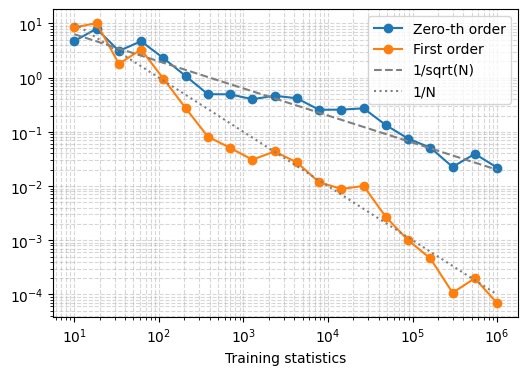

In [6]:
dim, n_states, n_outcomes = 2, 20, 10  # gives a 10x20 P matrix
training_states = [qutip.rand_ket(dim) for _ in range(n_states)]
povm = random_rank1_povm(dim, n_outcomes)
Ptrue = measure_povm(states=training_states, povm=povm, statistics=np.inf, return_frequencies=True)

train_stat_list = logspace(10, 10**6, num=20)
data = dict(err_0=[], err_1=[], train_stat=train_stat_list)
for train_stat in tqdm(train_stat_list, desc='Training statistics'):
    eps = 1 / np.sqrt(train_stat)
    Pest = measure_povm(states=training_states, povm=povm, statistics=train_stat, return_frequencies=True)
    X = (Pest - Ptrue) / eps
    # zero-th order approximation of the pseudoinverse
    approximator_0 = PseudoInverseApproximator(P_true=Ptrue, eps=eps, X=X)
    approximator_0.approximate(order=0)
    alleged_pinv_0 = approximator_0.approx_pinv
    # 1-st order approximation of the pseudoinverse
    approximator_1 = PseudoInverseApproximator(P_true=Ptrue, eps=eps, X=X)
    approximator_1.approximate(order=1)
    alleged_pinv_1 = approximator_1.approx_pinv
    # compute the real (estimated) pseudoinverse and then extract the blocks
    err_0 = np.linalg.norm(np.linalg.pinv(Pest) - alleged_pinv_0, ord=2)
    err_1 = np.linalg.norm(np.linalg.pinv(Pest) - alleged_pinv_1, ord=2)
    # store result
    data['err_0'].append(err_0)
    data['err_1'].append(err_1)
    
# plot the errors as a function of the training statistics
plt.figure(figsize=(6,4))
plt.plot(data['train_stat'], data['err_0'], label='Zero-th order', marker='o')
plt.plot(data['train_stat'], data['err_1'], label='First order', marker='o')
# plot also a line 1/sqrt(N) and a line 1/N
plt.plot(data['train_stat'], 20/np.sqrt(np.array(data['train_stat'])), label='1/sqrt(N)', linestyle='--', color='gray')
plt.plot(data['train_stat'], 100/np.array(data['train_stat']), label='1/N', linestyle=':', color='gray')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Training statistics')
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.legend()
plt.show()